### Install and import packages

In [ ]:
# install sktime, darts packages
%pip install sktime[all_extras]
%pip install u8darts[all]
%pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import requests
import io
import json

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series, plot_correlations, plot_acf, plot_pacf, plot_lags
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.linear_model import LinearRegression
from sktime.forecasting.arima import AutoARIMA
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

# Introduction

# Data Collection

### Get and Prepare Covid19 dataset from public sources (Alberta Health & Covid19 Tracker)

In [8]:
# Load COVID19 AB dataset from "AB Health Summary" and "COVID19 Tracker" datasets 
COVID_AB_STATS_SUMMARY_DOWNLOAD_URL = "https://www.alberta.ca/data/stats/covid-19-alberta-statistics-summary-data.csv"
COVID_TRACKER_DOWNLOAD_URL = "https://api.covid19tracker.ca/reports/province/ab"

# read AB Health Summary dataset
req = requests.get(COVID_AB_STATS_SUMMARY_DOWNLOAD_URL)
url_content = req.content
ab_summary_data = pd.read_csv(io.StringIO(url_content.decode('utf-8')))
ab_summary_data.rename(columns={'Date reported to Alberta Health': 'date'}, inplace=True)
ab_summary_data.drop('Unnamed: 0', axis=1, inplace=True)
ab_summary_data['date'] = pd.to_datetime(ab_summary_data['date'], yearfirst=True)
ab_summary_data.set_index('date', inplace=True)

# read COVID19 Tracker dataset
data = requests.get(COVID_TRACKER_DOWNLOAD_URL).text
data = json.loads(data)
covid_tracker_data = pd.DataFrame(data['data'])
covid_tracker_data['date'] = pd.to_datetime(covid_tracker_data['date'], yearfirst=True)
covid_tracker_data.set_index('date', inplace=True)

# prepare the full dataset
covid19_dataset = ab_summary_data
covid19_dataset['total_vaccinated'] = covid_tracker_data['total_vaccinated'].loc[covid19_dataset.index]
covid19_dataset.columns = covid19_dataset.columns.str.replace(' ','_')
covid19_dataset.columns = covid19_dataset.columns.str.lower()
# make sure the date index frequency is set to daily (to check the frequency use "covid19_dataset.index")
covid19_dataset = covid19_dataset.asfreq(freq='D')

In [23]:
# prepare datasets for overall comparison and for comparing with AltaML work
covid19_dataset = covid19_dataset['2020-03-06':'2022-02-16']
covid19_dataset_altaml = covid19_dataset['2020-03-06':'2021-06-30']

# Time Series Exploratory Data Analysis (EDA)

Can be implemented in Tableau and added to the final dashboard. It can help the users derive more insights from the dataset

### Visualize the daily number of cases vs. daily hospitalizations and positivity rate

From the plot below, we can clearly see that the daily number of cases and the positivity rate follow the same trend and fluctuation.

While daily hospitalizations also follows the same trend, we can see lagged effect, where hospitalizations start to increase after the daily cases increase. We can also see that the lag effect between the daily cases and daily hospitalizations is not the same in all waves. That may be explained by the nature of the virus/variant and how quickly an infected individual may be hospitalized.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='number_of_cases'>)

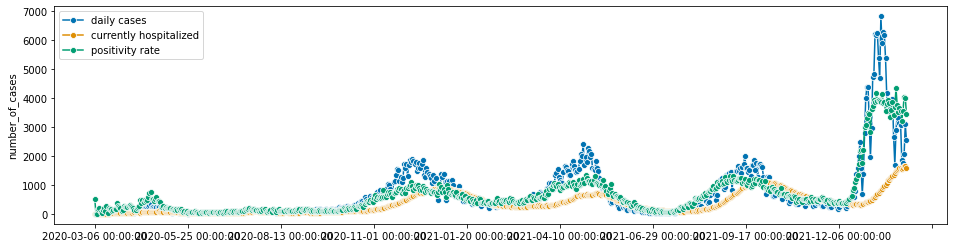

In [ ]:
number_of_cases=covid19_dataset['number_of_cases']
active_cases=covid19_dataset['active_cases']
currently_hospitalized = covid19_dataset['currently_hospitalized']
currently_in_icu = covid19_dataset['currently_in_icu']
number_of_variants_of_concern = covid19_dataset['number_of_variants_of_concern']
percent_positivity = covid19_dataset['percent_positivity']*100
total_vaccinated = covid19_dataset['total_vaccinated']
#trend = number_of_cases.rolling(7).mean()

plot_series(number_of_cases, currently_hospitalized, percent_positivity, 
            labels=['daily cases', 'currently hospitalized', 'positivity rate'])

### ACF and PACF plots
**The Autocorrelation plot (ACF)**

ACF plot measures the linear relationship between the timeseries and its past (lagged) values.

Trend, seasonality and cylic in ACF plot
The ACF of a timeseries that has a trend tend to have positive values that gradually decrease. Here, we can see the autocorrelation for small lag values is positive and is larger than other lag values. This indicates a trend.

When seasonality is present, the autocorrelation value will be larger at different lag values that are at a fixed distance from each other, which would indicate the seasonality type (yearly, monthly, weekly, daily, etc.)
In our case, there is no clear pattern of seasonality in the ACF plot. However, there is a cyclic patter that corresponds with the multiple waves present in the time series.


**The Partial autocorrelation plot (PACF)**

While ACF measures the relationship between the timeseries and its lagged values, PACF measure the relationship between the timeseries and its lagged values after removing the effect of earlier lags.
In our case, PACF indicates that present observations of the timeseries are mostly explained by the nearest lags, while some further lags still have significant partial correlation with the timeseries.
This indicates that nearest past observations of the timeseries are good predictors of the present observations.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='number_of_cases'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

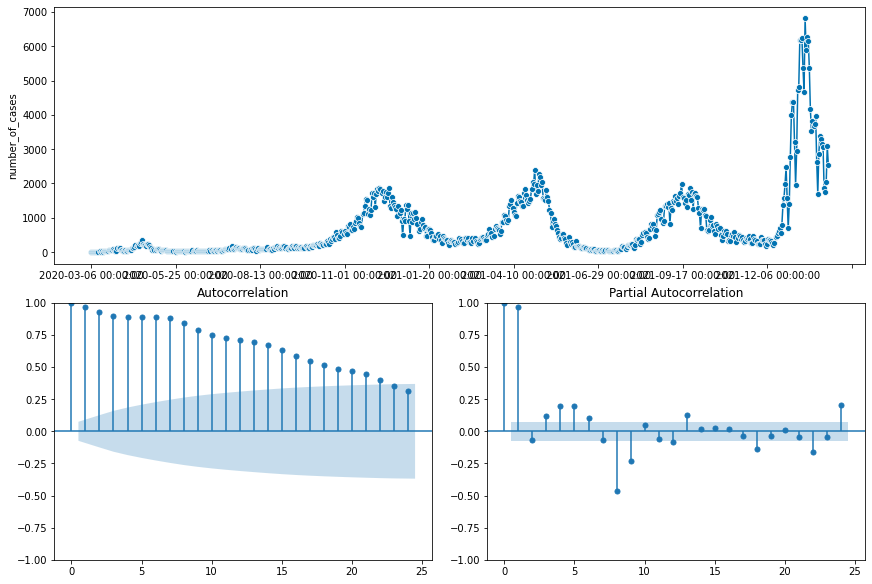

In [ ]:
# plot the the daily number of cases timeseries with ACF and PACF plots
plot_correlations(number_of_cases)

### Explore the relationship between the daily number of cases and other possible predictors

While it is common to calculate the correlation coefficents to measure the relationship between variables, that only measrures the strength of the linear relationship. Where the relationship is non-linear, scatter plots can be more informative.

From the plots below, we can see a positive linear relationship between the "daily number of cases" and the "active number of cases". The same can be observed with the "percent positivity".

Although the relationship between the daily number of cases and the testing positivity rate seems linear, as the positivity rate go higher, the relationship takes more of an exponential curve.

Another interesting observation is the relationship between the daily number of cases and the vaccination rate. As the vaccination numbers grow, we can see the number of cases decreases up to a certain point, where the number of cases jumped despite the increasing number of vaccinations. The same pattern can be observed in the number of currently hospitalized, currently in ICU, and the number of deaths. This might be due to the fact that most infections are happening amongst unvaccinated individuals. It can also be attributed to the presence of more variants of concern.

Based on the correlation coefficient values and the scatterplots below, I believe the following variables can help the predictive model:

* active_cases
* percent_positivity
* currently_hospitalized  


Further analysis, using time-based cross-validation, will be used to determine how helpful the variables are for the model's performance.

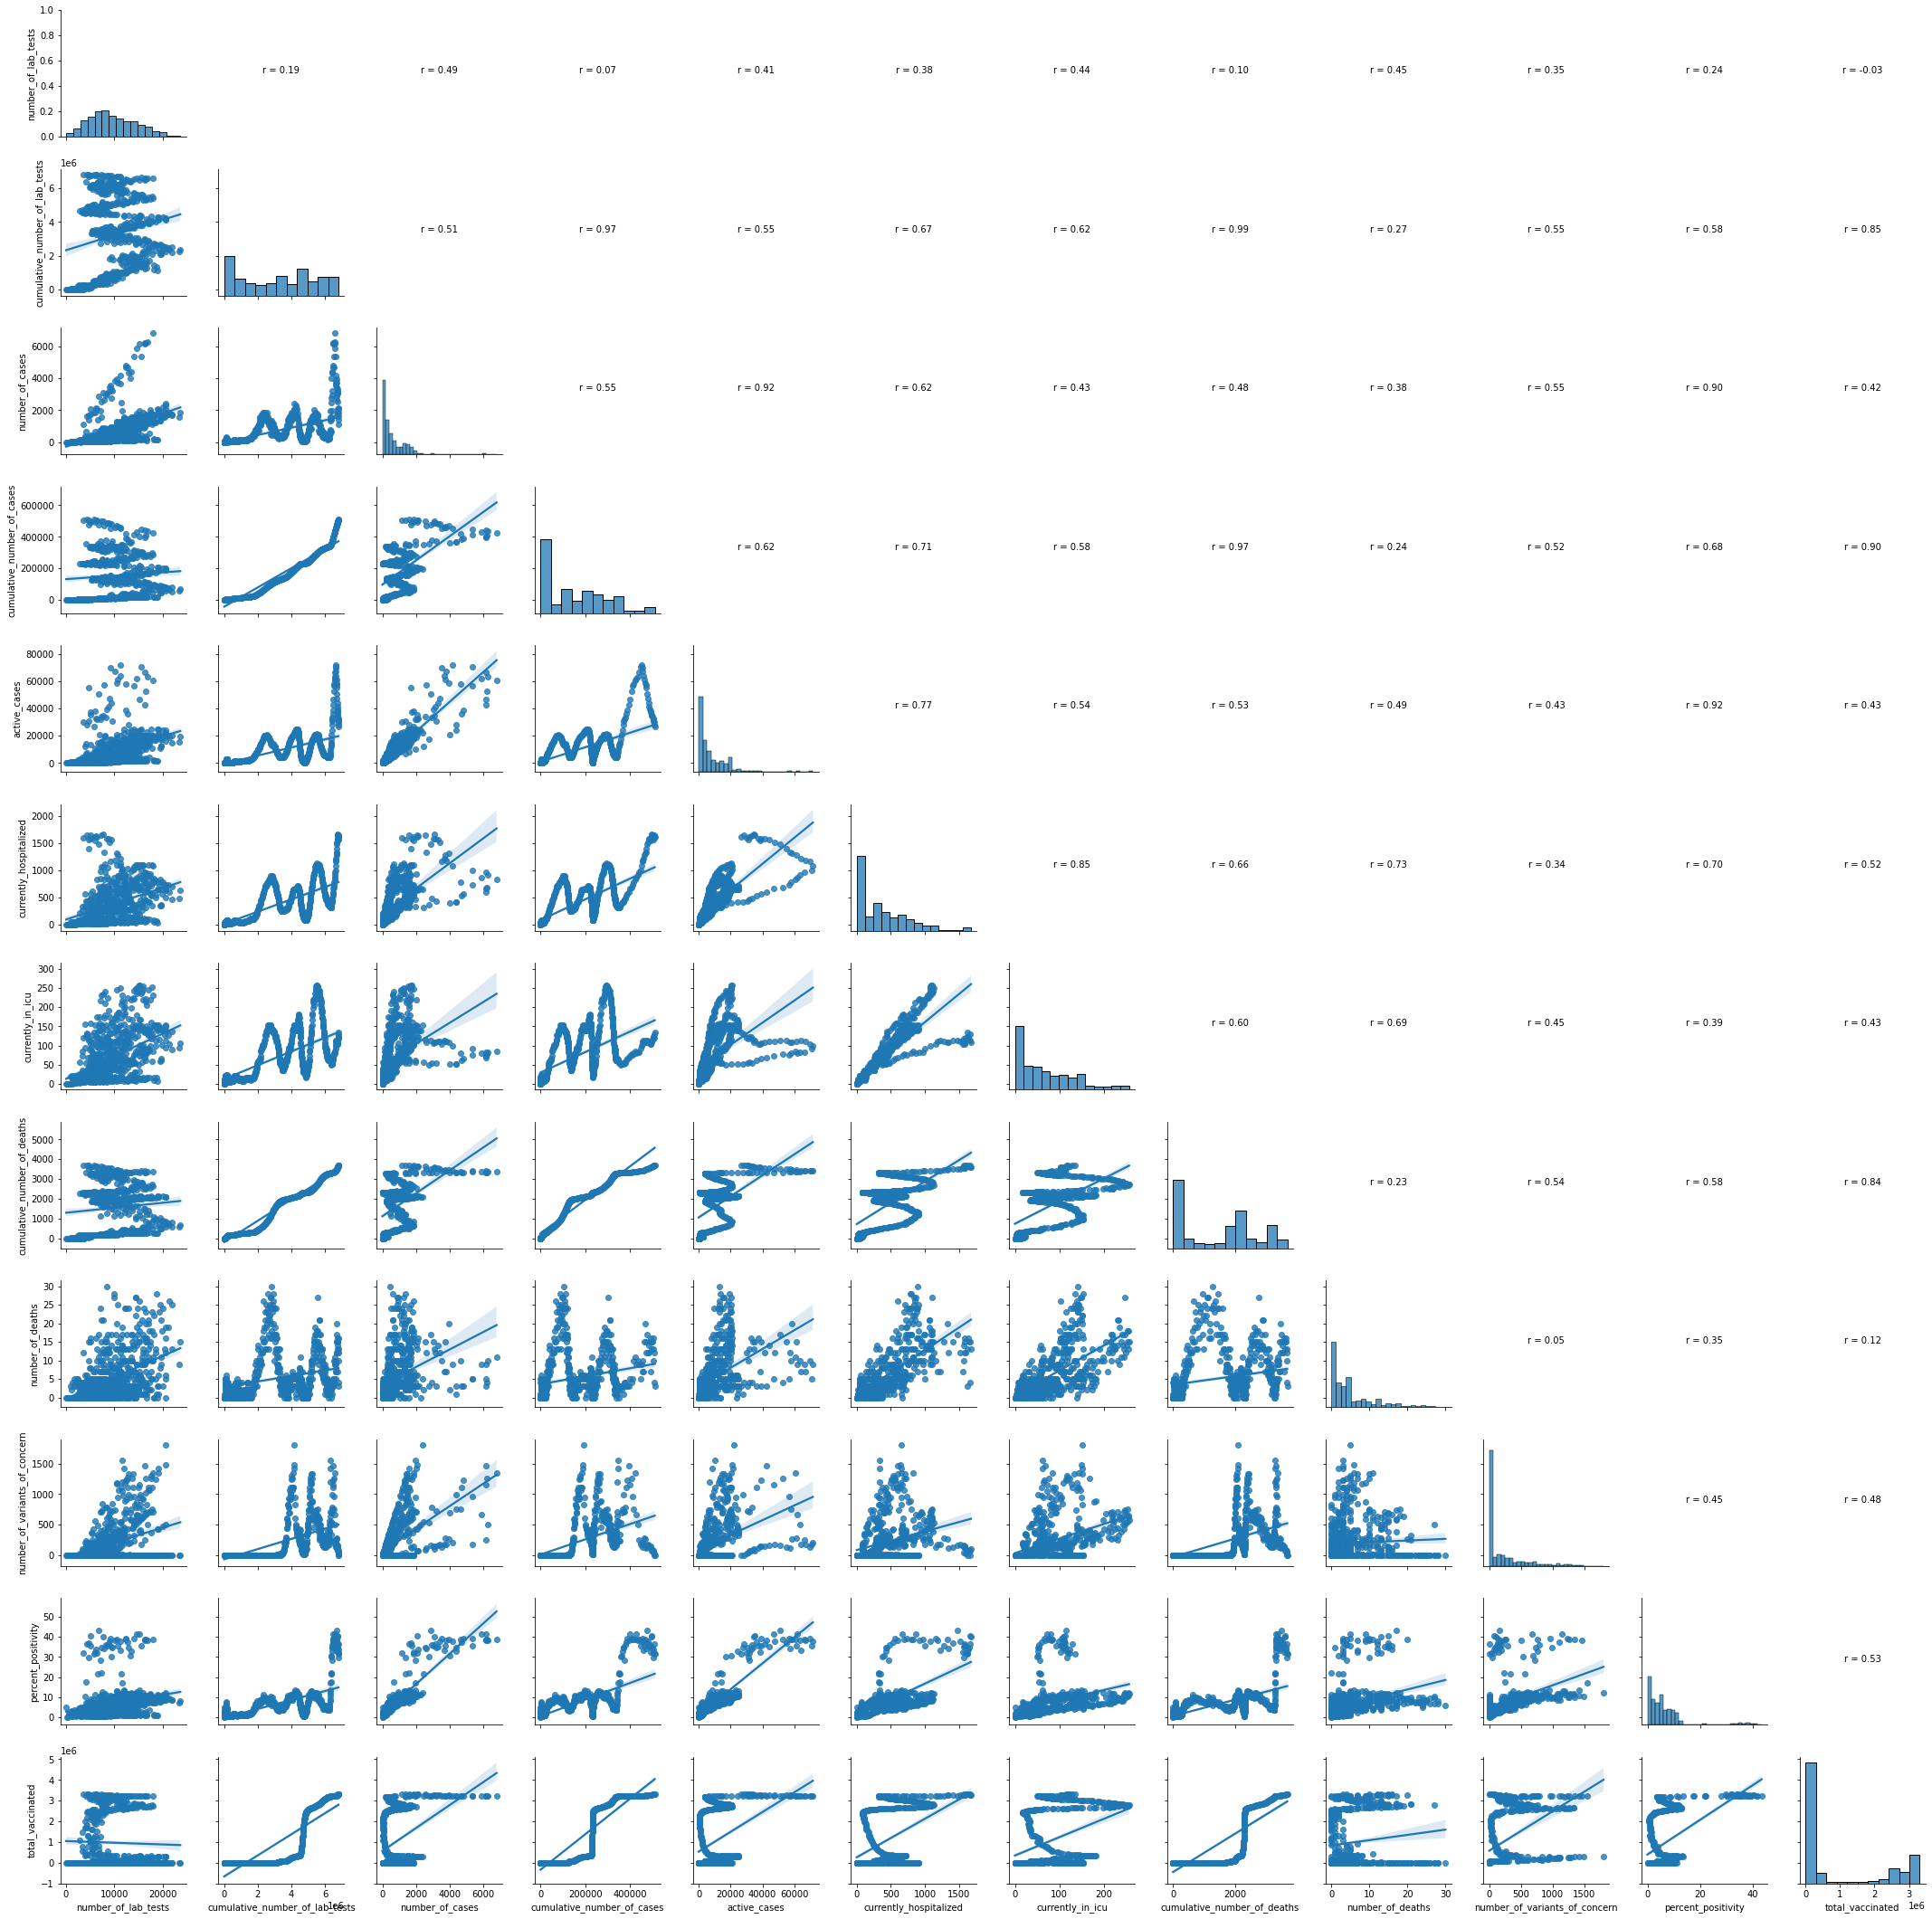

In [ ]:
# Scatterplots to visualize relationship between different variables
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

g = sns.PairGrid(covid19_dataset)
g.map_diag(sns.histplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)


### Explore the overall trends of the daily number of cases at the monthly, and weekly levels

From the plots below, We can observe the following:


*   At the weekday level, there is a pattern of decreasing trend from Friday till Monday, on average. This may be attributed to the testing strategy and the schedule of when the lab results are reported.
*   At the monthly level, different patterns can be observed over the past years. This may be attributed to public health policies and to the emergence of variants of concerns.



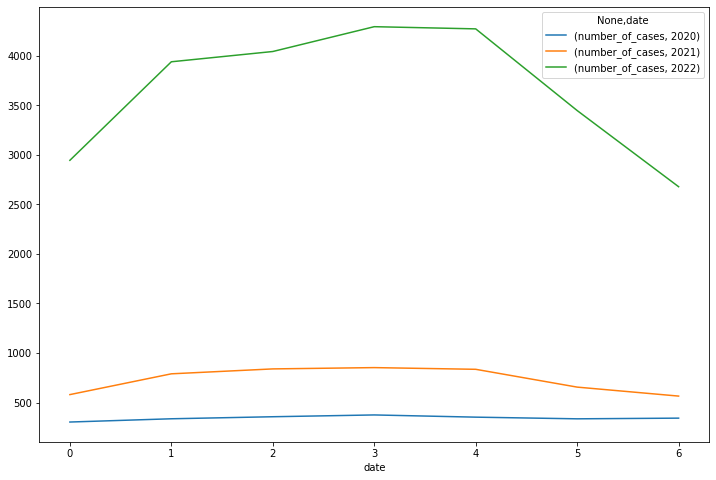

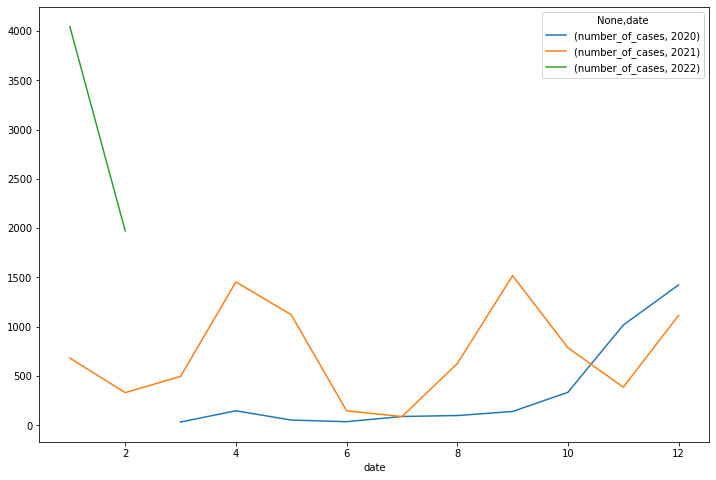

In [ ]:
from IPython.core.pylabtools import figsize
import pandas as pd
import seaborn as sns
import calendar

def seasonal_plot(df, season='year', index='month', column=None):
    """
    Reference: https://gist.github.com/arthurcgusmao/39905499340d28fa59834f652905dcec#file-seasonal_plot-py
    Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    Arguments:
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

seasonal_plot(covid19_dataset, season='year', index='weekday', column='number_of_cases')
seasonal_plot(covid19_dataset, season='year', index='month', column='number_of_cases')

# Model Training and Evaluation

After collecting the dataset and exploring different patterns, the model training and evaluation process can be broken down into the following sections:
* Evaluation of different covariates/predictors and how useful they would be for the model's performance
* Using the best covariates, train different Types of models: statistical, machine learning regressors, and deep learning models.
* Conclusion

### Evaluate different covariates/predictors 
In this section, one model (LightGBM) is trained with different combinations of past covariates (predictors), then backtested with 42 days ahead forecast.

The purpose of this exercise is to choose the predictors that would best help the performance of the model.

From the plots below, the model performed best, with MAE=476.12, when the following covariates were added:
* 'percent_positivity'
* 'active_cases'

100%|██████████| 601/601 [02:12<00:00,  4.54it/s]


LGBModel-Covariates(None) - MAE = 526.66


100%|██████████| 601/601 [03:57<00:00,  2.53it/s]


LGBModel-Covariates(['percent_positivity']) - MAE = 492.32


100%|██████████| 601/601 [05:39<00:00,  1.77it/s]


LGBModel-Covariates(['percent_positivity', 'active_cases']) - MAE = 476.12


100%|██████████| 601/601 [05:29<00:00,  1.82it/s]


LGBModel-Covariates(['percent_positivity', 'currently_hospitalized']) - MAE = 499.94


100%|██████████| 601/601 [07:14<00:00,  1.38it/s]


LGBModel-Covariates(['percent_positivity', 'currently_hospitalized', 'active_cases']) - MAE = 489.68


100%|██████████| 601/601 [03:57<00:00,  2.53it/s]


LGBModel-Covariates(['active_cases']) - MAE = 518.78


100%|██████████| 601/601 [05:29<00:00,  1.82it/s]


LGBModel-Covariates(['active_cases', 'currently_hospitalized']) - MAE = 558.84


100%|██████████| 601/601 [03:50<00:00,  2.60it/s]


LGBModel-Covariates(['currently_hospitalized']) - MAE = 570.90


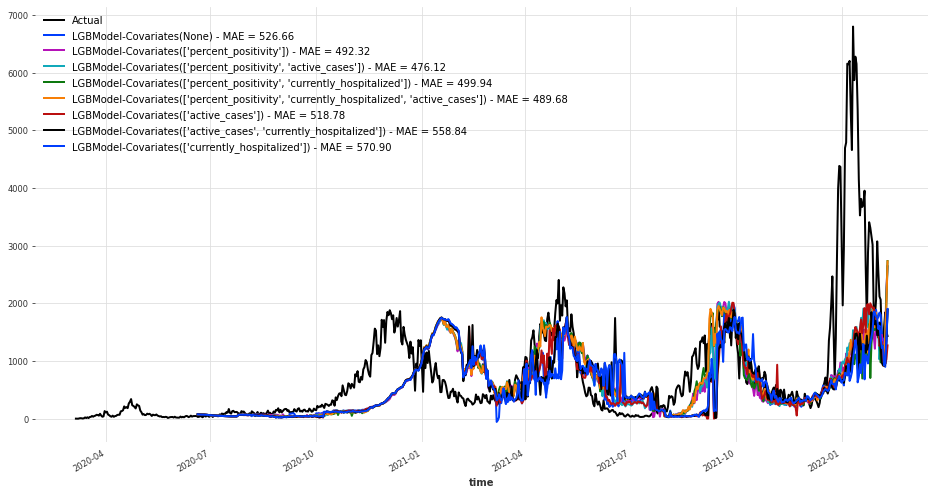

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import RegressionModel, LightGBMModel, RandomForest
from sklearn.linear_model import BayesianRidge
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True):
  model_name = str(model).partition("(")[0]
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# different covariates
X = covid19_dataset[['percent_positivity']]
X1 = covid19_dataset[['percent_positivity', 'active_cases']]
X2 = covid19_dataset[['percent_positivity', 'currently_hospitalized']]
X3 = covid19_dataset[['percent_positivity', 'currently_hospitalized', 'active_cases']]
X4 = covid19_dataset[['active_cases']]
X5 = covid19_dataset[['active_cases', 'currently_hospitalized']]
X6 = covid19_dataset[['currently_hospitalized']]

# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))
X_series_1 = TimeSeries.from_series(pd.concat([X1, pd.DataFrame(columns=X1.columns, index=future_dates)]))
X_series_2 = TimeSeries.from_series(pd.concat([X2, pd.DataFrame(columns=X2.columns, index=future_dates)]))
X_series_3 = TimeSeries.from_series(pd.concat([X3, pd.DataFrame(columns=X3.columns, index=future_dates)]))
X_series_4 = TimeSeries.from_series(pd.concat([X4, pd.DataFrame(columns=X4.columns, index=future_dates)]))
X_series_5 = TimeSeries.from_series(pd.concat([X5, pd.DataFrame(columns=X5.columns, index=future_dates)]))
X_series_6 = TimeSeries.from_series(pd.concat([X6, pd.DataFrame(columns=X6.columns, index=future_dates)]))

# fit and predict with different combinations of covariates
lgbm = LightGBMModel(lags=60)
lgbm_covar = LightGBMModel(lags=60, lags_past_covariates=60)
catboost_covar = RegressionModel(lags=60, lags_past_covariates=60, model=CatBoostRegressor(silent=True))
xgb_covar = RegressionModel(lags=60, lags_past_covariates=60, model=XGBRegressor(silent=True))

# plot
y_series.plot(label="Actual")

# backtesting with different covariates
historicalForecast_model(model=lgbm, ts=y_series, past_covariates=None, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_1, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_2, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_3, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_4, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_5, start=65, fh=forecast_period)
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series_6, start=65, fh=forecast_period)


### Compare Models:
* **Statistical models**: AutoARIMA, Exponential Smoothing, Theta, and Prophet. Those models only support future-known covariates. In our case, we only have past-known covariates. The models in this category are evaluated without covariates or external predictors.
* **Machine Learning Regressors**: CatBoost, XGBoost, LightGBM, RandomForest. The regression models support past-covariates so they will be trained and evaluated using the best covariates/predictors identified in the previous section.
* **Deep Learning**: BlockRNNModel(VanillaRNN, LSTM, GRU), NBEATSModel, TCNModel

The models are evaluated using time-based cross-validation or backtesting, a methodology that simulates the models forecasting behavior in real settings. Evaluating using a testing set only may not accurately reflect the true performance over time.




#### Statistical Models
The following models are trained without covariates as they do not support past-known covariates:
* Prophet
* AutoARIMA
* Theta
* Exponential Smoothing




100%|██████████| 604/604 [00:15<00:00, 39.93it/s]


Theta-Covariates(None) - MAE = 762.77


100%|██████████| 604/604 [01:34<00:00,  6.41it/s]


ExponentialSmoothing-Covariates(None) - MAE = 1048.19


100%|██████████| 604/604 [20:41<00:00,  2.06s/it]


Prophet-Covariates(None) - MAE = 977.29


100%|██████████| 604/604 [2:22:59<00:00, 14.20s/it]


Auto-ARIMA-Covariates(None) - MAE = 916.79


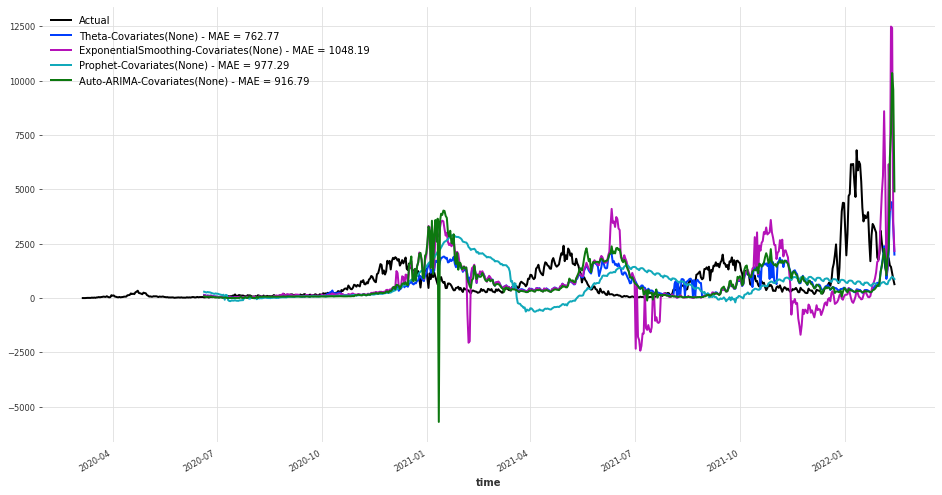

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.models import BlockRNNModel, NBEATSModel, TCNModel, TFTModel
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True):
  model_name = str(model).partition("(")[0]
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Statistical models
historicalForecast_model(Theta(season_mode=SeasonalityMode.ADDITIVE), y_series, start=65, fh=forecast_period, verbose=True)
historicalForecast_model(ExponentialSmoothing(), y_series, start=65, fh=forecast_period, verbose=True)
historicalForecast_model(Prophet(daily_seasonality=False, yearly_seasonality=False), y_series, start=65, fh=forecast_period, verbose=True)
historicalForecast_model(AutoARIMA(), y_series, start=65, fh=forecast_period, verbose=True)

#### Machine Learning Regression Models
The following models are trained with the best past-covariates identified earlier, which are the "percent_positivity" and "active_cases":
* CatBoost
* XGBoost
* RandomForest
* LightGBM

  0%|          | 0/552 [00:00<?, ?it/s]

RandomForrest-Covariates(['percent_positivity', 'active_cases']) - MAE = 602.79


  0%|          | 0/552 [00:00<?, ?it/s]

LightGBM-Covariates(['percent_positivity', 'active_cases']) - MAE = 535.11


  0%|          | 0/552 [00:00<?, ?it/s]

CatBoost-Covariates(['percent_positivity', 'active_cases']) - MAE = 499.00


  0%|          | 0/552 [00:00<?, ?it/s]

[22:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:27:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:27:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

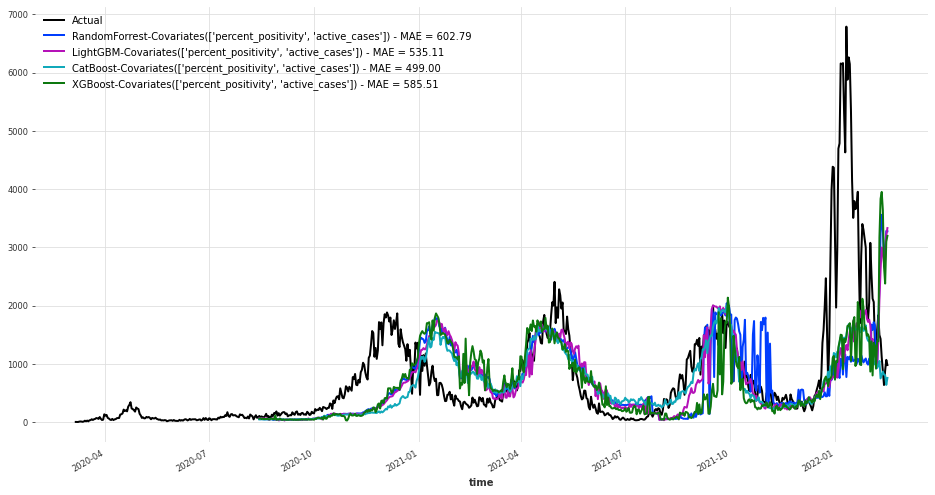

In [22]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.models import BlockRNNModel, NBEATSModel, TCNModel
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True, model_name=None):
  model_name = model_name
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Regression models
lgbm_covar = LightGBMModel(lags=60, lags_past_covariates=60)
rf_covar = RandomForest(lags=60, lags_past_covariates=60)
catboost_covar = RegressionModel(lags=60, lags_past_covariates=60, model=CatBoostRegressor(silent=True))
xgb_covar = RegressionModel(lags=60, lags_past_covariates=60, model=XGBRegressor(silent=True))

# backtesting - Regression models
historicalForecast_model(model=rf_covar, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period, model_name='RandomForrest')
historicalForecast_model(model=lgbm_covar, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period, model_name='LightGBM')
historicalForecast_model(model=catboost_covar, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period, model_name='CatBoost')
historicalForecast_model(model=xgb_covar, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period, model_name='XGBoost')

##### Training ML regression models Without covariates
* CatBoost
* XGBoost
* RandomForest
* LightGBM

  0%|          | 0/552 [00:00<?, ?it/s]

RandomForest-Covariates(None) - MAE = 727.52


  0%|          | 0/552 [00:00<?, ?it/s]

LightGBM-Covariates(None) - MAE = 581.37


  0%|          | 0/552 [00:00<?, ?it/s]

CatBoost-Covariates(None) - MAE = 604.00


  0%|          | 0/552 [00:00<?, ?it/s]

[15:55:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

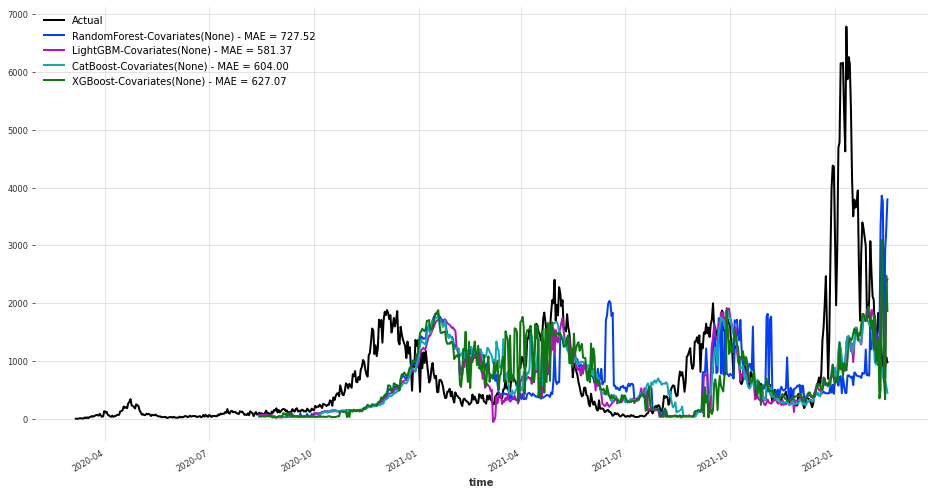

In [20]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True, model_name=None):
  model_name = model_name
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Regression models without covariates
lgbm = LightGBMModel(lags=60)
rf = RandomForest(lags=60)
catboost = RegressionModel(lags=60, model=CatBoostRegressor(silent=True))
xgb = RegressionModel(lags=60, model=XGBRegressor(silent=True))

# backtesting - Regression models
historicalForecast_model(model=rf, ts=y_series, start=120, fh=forecast_period, model_name='RandomForest')
historicalForecast_model(model=lgbm, ts=y_series, start=120, fh=forecast_period, model_name='LightGBM')
historicalForecast_model(model=catboost, ts=y_series, start=120, fh=forecast_period, model_name='CatBoost')
historicalForecast_model(model=xgb, ts=y_series, start=120, fh=forecast_period, model_name='XGBoost')

#### Deep Learning Models
The following models are trained with the best past-covariates identified earlier, which are the "percent_positivity" and "active_cases":
* Vanilla RNN (Recurrent Neural Networks)
* LSTM (Long Short Term Memory)
* GRU (Gate Recurrent Units)
* TCNModel (Temporal Convolutional Networks)

In [24]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.models import BlockRNNModel, NBEATSModel, TCNModel
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import logging 

# set figure size
plt.figure(figsize=(16,8))
logging.disable(logging.INFO) # disable unnecessary messages
logging.disable(logging.WARNING)


# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True):
  model_name = model.model_name
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Deep Learning models
nbeats = NBEATSModel(input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="NBEATS", force_reset=True)
vanillaRNN = BlockRNNModel(model='RNN', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="BlockRNN-VanillaRNN", force_reset=True)
lstm = BlockRNNModel(model='LSTM', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="BlockRNN-LSTM", force_reset=True)
gru = BlockRNNModel(model='GRU', input_chunk_length=21, output_chunk_length=42, random_state=12, model_name="BlockRNN-GRU", force_reset=True)
tcn = TCNModel(input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="TCN", force_reset=True)

# backtesting - Deep Learning models
#historicalForecast_model(model=nbeats, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)
historicalForecast_model(model=vanillaRNN, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)
historicalForecast_model(model=lstm, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)
historicalForecast_model(model=gru, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)
historicalForecast_model(model=tcn, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)

  0%|          | 0/552 [00:00<?, ?it/s]

BlockRNN-VanillaRNN-Covariates(['percent_positivity', 'active_cases']) - MAE = 684.65


  0%|          | 0/552 [00:00<?, ?it/s]

BlockRNN-LSTM-Covariates(['percent_positivity', 'active_cases']) - MAE = 664.88


  0%|          | 0/552 [00:00<?, ?it/s]

##### Training Deep Learning models without covariates

  0%|          | 0/552 [00:00<?, ?it/s]

BlockRNN-VanillaRNN-Covariates(None) - MAE = 728.31


  0%|          | 0/552 [00:00<?, ?it/s]

BlockRNN-LSTM-Covariates(None) - MAE = 698.78


  0%|          | 0/552 [00:00<?, ?it/s]

BlockRNN-GRU-Covariates(None) - MAE = 719.77


  0%|          | 0/552 [00:00<?, ?it/s]

RNN-VanillaRNN-Covariates(None) - MAE = 823.02


  0%|          | 0/552 [00:00<?, ?it/s]

RNN-LSTM-Covariates(None) - MAE = 830.54


  0%|          | 0/552 [00:00<?, ?it/s]

RNN-GRU-Covariates(None) - MAE = 866.53


  0%|          | 0/552 [00:00<?, ?it/s]

TCN-Covariates(None) - MAE = 1068.58


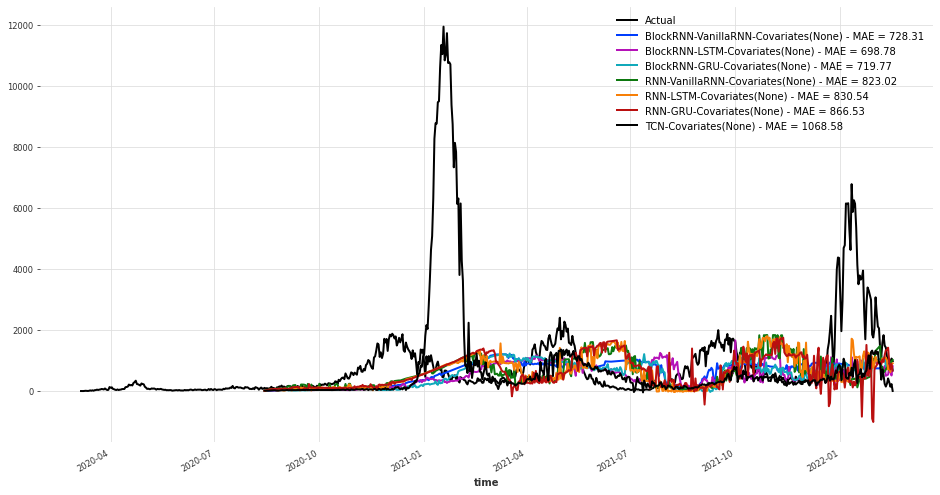

In [12]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.models import BlockRNNModel, RNNModel, NBEATSModel, TCNModel
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import logging 

# set figure size
plt.figure(figsize=(16,8))
logging.disable(logging.INFO) # disable unnecessary messages
logging.disable(logging.WARNING)


# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True):
  model_name = model.model_name
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Deep Learning models
nbeats = NBEATSModel(input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="NBEATS")
tcn = TCNModel(input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="TCN")
# BlockRNN models
blockVanillaRNN = BlockRNNModel(model='RNN', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="BlockRNN-VanillaRNN")
blockLstm = BlockRNNModel(model='LSTM', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="BlockRNN-LSTM")
blockGru = BlockRNNModel(model='GRU', input_chunk_length=21, output_chunk_length=42, random_state=12, model_name="BlockRNN-GRU")
# RNN models
vanillaRNN = RNNModel(model='RNN', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="RNN-VanillaRNN")
lstm = RNNModel(model='LSTM', input_chunk_length=60, output_chunk_length=42, random_state=12, model_name="RNN-LSTM")
gru = RNNModel(model='GRU', input_chunk_length=21, output_chunk_length=42, random_state=12, model_name="RNN-GRU")


# backtesting - Deep Learning models
#historicalForecast_model(model=nbeats, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)
#historicalForecast_model(model=tcn, ts=y_series, past_covariates=X_series, start=120, fh=forecast_period)

# backtesting blockRNN models without covariates
historicalForecast_model(model=blockVanillaRNN, ts=y_series, start=120, fh=forecast_period)
historicalForecast_model(model=blockLstm, ts=y_series, start=120, fh=forecast_period)
historicalForecast_model(model=blockGru, ts=y_series, start=120, fh=forecast_period)
# backtesting RNN models without covariates
historicalForecast_model(model=vanillaRNN, ts=y_series, start=120, fh=forecast_period)
historicalForecast_model(model=lstm, ts=y_series, start=120, fh=forecast_period)
historicalForecast_model(model=gru, ts=y_series, start=120, fh=forecast_period)
# backtesting TCN model without covariates
historicalForecast_model(model=tcn, ts=y_series, start=120, fh=forecast_period)


#### Compare ML regression models with AltaML work using the same time period (up to June 2021)

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
from darts.models import RegressionModel, LightGBMModel, RandomForest
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# funtion for model's historical evaluation
def historicalForecast_model(model=None, ts=None, past_covariates=None, future_covariates=None, start=None, stride=1,
                             retrain=True, overlap_end=False, last_points_only=True, fh=None, verbose=True, model_name=None):
  model_name = model_name
  past_covariates_columns=""
  if(past_covariates==None):
    past_covariates_columns="None"
  else:
    past_covariates_columns=list(past_covariates.columns)
  # perform backtesting
  historical_fcast = model.historical_forecasts(ts, past_covariates=past_covariates, future_covariates=future_covariates,
                                                start=start, stride=stride, forecast_horizon=fh, verbose=verbose)
  historical_fcast.plot(label="{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))
  print("{}-Covariates({}) - MAE = {:.2f}".format(model_name, past_covariates_columns, mae(historical_fcast, ts)))

# dataset 
forecast_period = 42
y = covid19_dataset_altaml['number_of_cases']
y_series = TimeSeries.from_series(y)
# best covariates
X = covid19_dataset_altaml[['percent_positivity', 'active_cases']]
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_series = TimeSeries.from_series(pd.concat([X, pd.DataFrame(columns=X.columns, index=future_dates)]))

# plot
y_series.plot(label="Actual")

# Models evaluation - Regression models without covariates
lgbm = LightGBMModel(lags=60)
rf = RandomForest(lags=60)
catboost = RegressionModel(lags=60, model=CatBoostRegressor(silent=True))
xgb = RegressionModel(lags=60, model=XGBRegressor(silent=True))

# backtesting - Regression models with the stride set to 30, to match AltaML's settings
historicalForecast_model(model=rf, ts=y_series, start=65, fh=forecast_period, stride=30, model_name='RandomForest')
historicalForecast_model(model=lgbm, ts=y_series, start=65, fh=forecast_period, stride=30, model_name='LightGBM')
historicalForecast_model(model=catboost, ts=y_series, start=65, fh=forecast_period, stride=30, model_name='CatBoost')
historicalForecast_model(model=xgb, ts=y_series, start=65, fh=forecast_period, stride=30, model_name='XGBoost')

### Forecast in deployment using Machine Learning Regressors with covariates

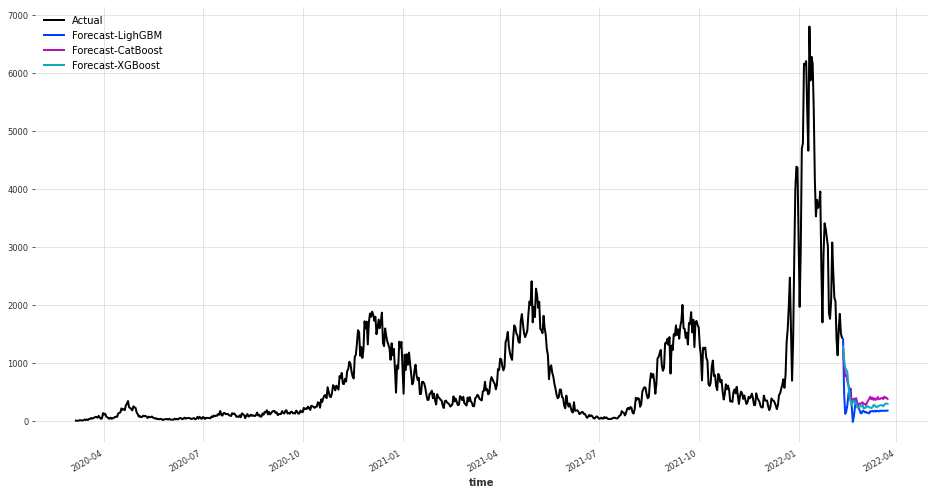

In [ ]:
from darts.models import RegressionModel, LightGBMModel, RandomForest
from sklearn.linear_model import BayesianRidge
from darts.metrics import mape, mae
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# set figure size
plt.figure(figsize=(16,8))

# dataset 
forecast_period = 42
y_series = TimeSeries.from_series(covid19_dataset['number_of_cases'])
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
# extend past covariates series to match the target series plus the forecast horizon (n value)
# https://unit8co.github.io/darts/userguide/covariates.html?highlight=past%20covariates
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D')
X_fh = X.iloc[[-1]*forecast_period] # the last point of X replicated 42 times
X_fh['percent_positivity']=None
X_fh.index=future_dates
X_extended = pd.concat([X, X_fh])
X_series = TimeSeries.from_series(X_extended)

# Train different models
model = LightGBMModel(lags=60, lags_past_covariates=60)
model1 = RegressionModel(lags=60, lags_past_covariates=60, model=CatBoostRegressor(silent=True))
model2 = RegressionModel(lags=60, lags_past_covariates=60, model=XGBRegressor(silent=True))
model.fit(y_series, past_covariates=X_series)
model1.fit(y_series, past_covariates=X_series)
model2.fit(y_series, past_covariates=X_series)

y_pred = model.predict(series=y_series, past_covariates=X_series, n=forecast_period)
y_pred1 = model1.predict(series=y_series, past_covariates=X_series, n=forecast_period)
y_pred2 = model2.predict(series=y_series, past_covariates=X_series, n=forecast_period)

y_series.plot(label="Actual")
y_pred.plot(label="Forecast-LighGBM")
y_pred1.plot(label="Forecast-CatBoost")
y_pred2.plot(label="Forecast-XGBoost")


### Summary of results
Here discuss the summary, constraints, and conclusions

# Models Evaluation using Sktime

Evaluating the model based on the test set alone may not be optimal. In real-life settings, we would like to assess the model's performance when it does multiple forecasts as time goes on.

For this purpose, sktime provides time-based cross-validation and it uses 2 methods to split the data for cross-validation, "Expanding Window" and "Sliding Window"

#### CatBoost - no covariates
     Strategy = 'direct',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 day


Overall MAE: 421.46084485718916


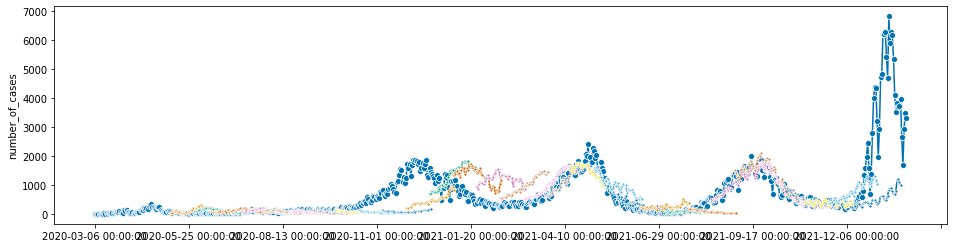

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError

y = covid19_dataset['number_of_cases']

# Use CatBoost Regressor (initialize with tuned parameters)
catRegressor = CatBoostRegressor(silent=True, od_type="Iter", od_wait=50) # for overfitting detection: od_type="Iter", od_wait=50
#catRegressor = CatBoostRegressor(silent=True, iterations=200, learning_rate=0.2, l2_leaf_reg=3, max_depth=5)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='direct', window_length=21, scitype='tabular-regressor')
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon) # step_length=20 gave the best MAE
crossVal_df = evaluate(forecaster=catboostForecaster, y=y, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);


#### CatBoost - no covariates
     Strategy = 'recursive',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 375.93891537989674


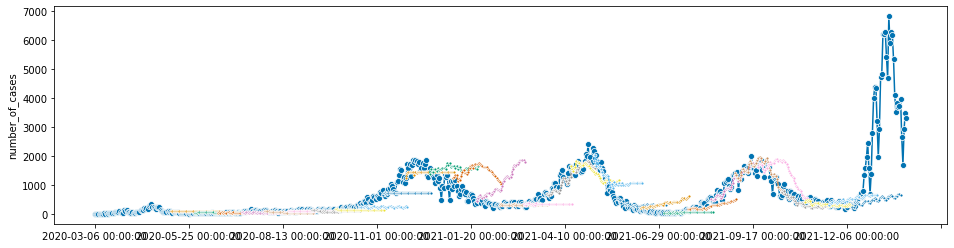

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError

y = covid19_dataset['number_of_cases']

# Use CatBoost Regressor (initialize with tuned parameters)
catRegressor = CatBoostRegressor(silent=True, od_type="Iter", od_wait=50) # for overfitting detection: od_type="Iter", od_wait=50
#catRegressor = CatBoostRegressor(silent=True, iterations=220, learning_rate=0.2, od_type="Iter", od_wait=50, l2_leaf_reg=3, max_depth=5)
catboostForecaster = make_reduction(estimator=catRegressor,  strategy='recursive', window_length=21, scitype='tabular-regressor')
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon) # step_length=20 gave the best MAE
crossVal_df = evaluate(forecaster=catboostForecaster, y=y, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);


#### XGBoost - no covariates
     Strategy = 'recursive',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 384.8304657285176


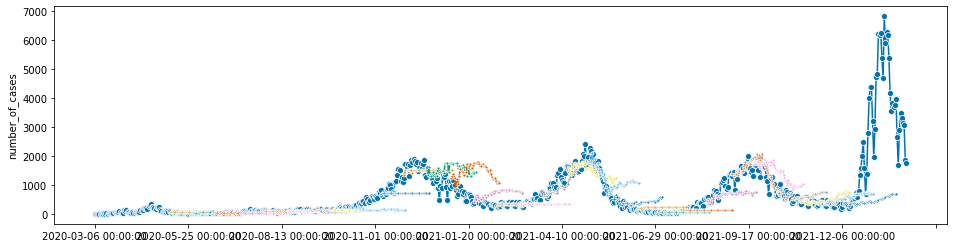

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from xgboost import XGBRegressor

y = covid19_dataset['number_of_cases']

# Use CatBoost Regressor (initialize with tuned parameters)
xgBoostRegressor = XGBRegressor(silent=True)
xgBoostForecaster = make_reduction(estimator=xgBoostRegressor, strategy='recursive', window_length=21, scitype='tabular-regressor')
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=xgBoostForecaster, y=y, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

#### XGBoost - no covariates
     Strategy = 'direct',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 400.85991824467976


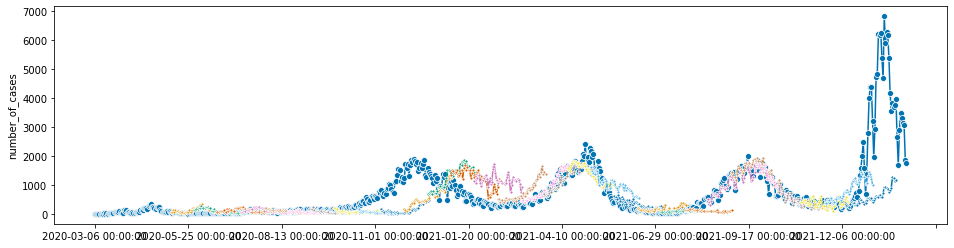

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from xgboost import XGBRegressor

y = covid19_dataset['number_of_cases']

# Use CatBoost Regressor (initialize with tuned parameters)
catRegressor = XGBRegressor(silent=True)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='direct', window_length=21, scitype='tabular-regressor')
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=catboostForecaster, y=y, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

#### Prophet:
     Forecast_horizon = 42 days

Overall MAE: 269.29675454423364


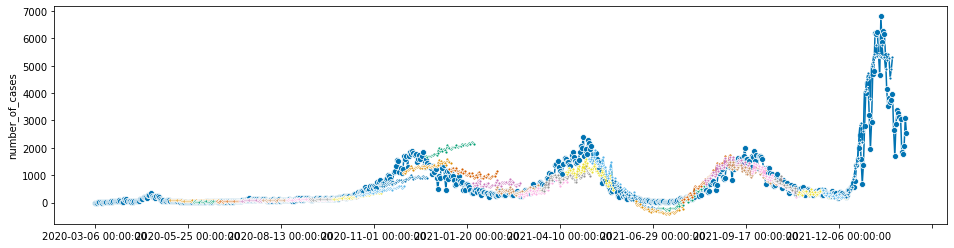

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.fbprophet import Prophet

y = covid19_dataset['number_of_cases']
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
# Use Prophet
fb_forecaster = Prophet(add_country_holidays={'country_name': 'Canada'},
                        yearly_seasonality=False,
                        weekly_seasonality=False,
                        daily_seasonality=False)
          
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=fb_forecaster, y=y, X=X, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

#### ARIMA/AutoARIMA:
     Forecast_horizon = 42 days

Overall MAE: 412.4562222937025


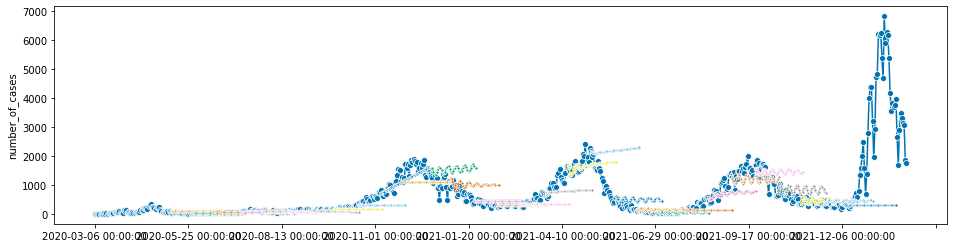

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arima import AutoARIMA, ARIMA

y = covid19_dataset['number_of_cases']
X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables

# ARIMA/AutoARIMA
autoArima_forecaster = AutoARIMA(suppress_warnings=True)
arima_forecaster = ARIMA(suppress_warnings=True)
          
forecastHorizon = list(range(1,43))

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=autoArima_forecaster, y=y, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

## Forecasting with exogenous variables

### CatBoost Regressor
     Strategy = 'recursive',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 303.8658298803432


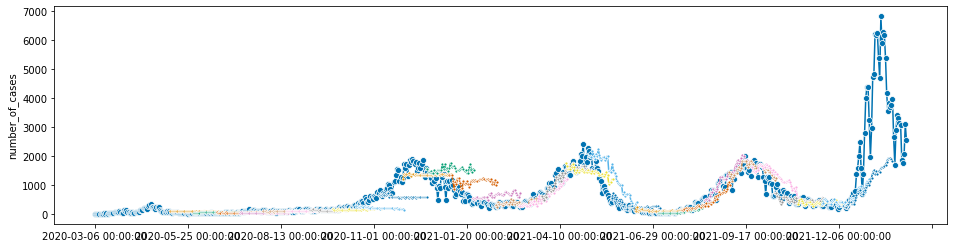

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from catboost import CatBoostRegressor

y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
forecastHorizon = list(range(1,43))

# Use CatBoost Regressor (initialize with tuned parameters)
catRegressor = CatBoostRegressor(silent=True, iterations=220, learning_rate=0.2, l2_leaf_reg=3, max_depth=5)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='recursive', window_length=21, scitype='tabular-regressor')

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=catboostForecaster, y=y, X=X, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);


### CatBoost Regressor
     Strategy = 'direct',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from catboost import CatBoostRegressor

y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
forecastHorizon = list(range(1,43))

# Use CatBoost Regressor (initialize with tuned parameters)
catRegressor = CatBoostRegressor(silent=True)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='direct', window_length=21, scitype='tabular-regressor')

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=catboostForecaster, y=y, X=X, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

### XGBoost Regressor
     Strategy = 'recursive',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 347.4368423234848


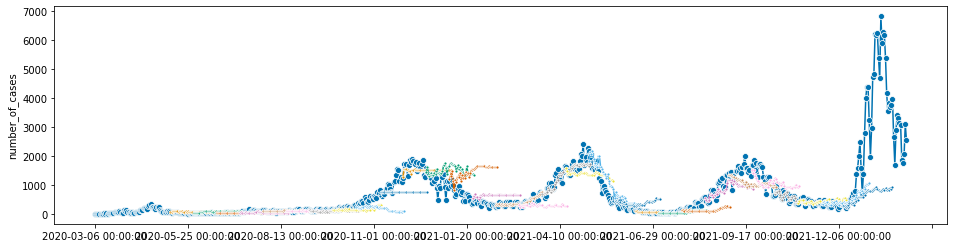

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from xgboost import XGBRegressor

y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
forecastHorizon = list(range(1,43))

# Use CatBoost Regressor (initialize with tuned parameters)
xgBoostRegressor = XGBRegressor(silent=True, max_depth=5, learning_rate=0.2)
xgBoostForecaster = make_reduction(estimator=xgBoostRegressor, strategy='recursive', window_length=21, scitype='tabular-regressor')

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=xgBoostForecaster, y=y, X=X, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

### XGBoost Regressor
     Strategy = 'direct',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Overall MAE: 422.35204922585257


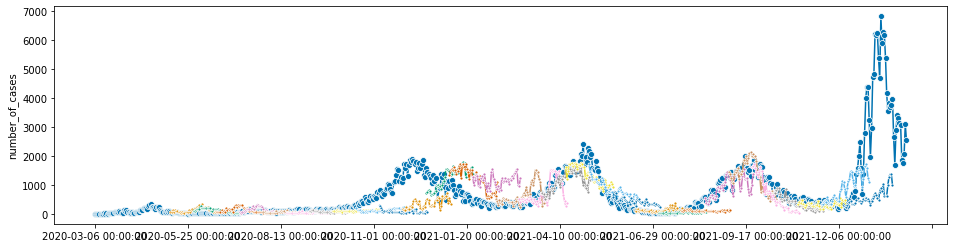

In [ ]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from xgboost import XGBRegressor

y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, covid19_dataset.columns == 'percent_positivity']
forecastHorizon = list(range(1,43))

# Use CatBoost Regressor (initialize with tuned parameters)
xgBoostRegressor = XGBRegressor(silent=True, max_depth=5, learning_rate=0.2)
xgBoostForecaster = make_reduction(estimator=xgBoostRegressor, strategy='direct', window_length=21, scitype='tabular-regressor')

cross_val = ExpandingWindowSplitter(initial_window=65, step_length=20, fh=forecastHorizon)
crossVal_df = evaluate(forecaster=xgBoostForecaster, y=y, X=X, cv=cross_val, strategy="refit", scoring=MeanAbsoluteError(), return_data=True)

# calculate the overall average of MAE
print("Overall MAE:", crossVal_df['test_MeanAbsoluteError'].mean())
plot_series(
    y, *[crossVal_df["y_pred"].iloc[x] for x in range(len(crossVal_df))],
    markers=["o", *["."]*len(crossVal_df)]);

## Forecasting (In-Deployment mode)

### CatBoost Regressor
     Strategy = 'recursive',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='number_of_cases'>)

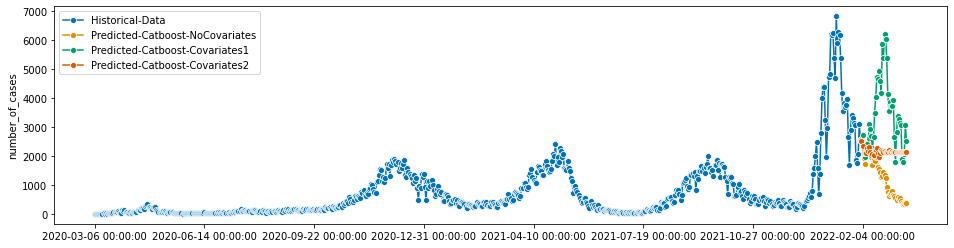

In [ ]:
forecast_period = 42 # forecast 21 days ahead
y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
future_dates = pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D') # Future dates

# X_future represents expgenous variables for the future forecasted period, for testing X_future is the last 42 points from X
X_future_1 = X.tail(forecast_period) # X_future_1 is the last 42 points of X
X_future_2 = X.iloc[[-1]*forecast_period] # X_future_2 is the last point of X replicated 42 times
X_future_2.index=future_dates



fh = ForecastingHorizon(pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D'), 
                             is_relative=False) # forecast horizon - absolute

# Use CatBoost Regressor (initialize with tuned hyperparameters)
catRegressor = CatBoostRegressor(silent=True, iterations=220, learning_rate=0.2, l2_leaf_reg=3, max_depth=5)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='recursive', window_length=21, scitype='tabular-regressor')
catboostForecasterNoCovariates = make_reduction(estimator=catRegressor, strategy='recursive', window_length=21, scitype='tabular-regressor')

# Note: when catboostForecaster's strategy is set to "direct", there is no need to pass exogenous variables values for the future (past covariates are enough)
catboostForecaster.fit(y=y, X=X, fh=fh)
catboostForecasterNoCovariates.fit(y=y, fh=fh)
y_pred_no_covariates = catboostForecasterNoCovariates.predict(fh=fh)
y_pred_1 = catboostForecaster.predict(X=X_future_1, fh=fh)
y_pred_2 = catboostForecaster.predict(X=X_future_2, fh=fh)

# plot
plot_series(y, y_pred_no_covariates, y_pred_1, y_pred_2, labels=["Historical-Data", "Predicted-Catboost-NoCovariates", "Predicted-Catboost-Covariates1", "Predicted-Catboost-Covariates2"])

### CatBoost Regressor
     Strategy = 'direct',
     forecast_horizon = 42 days,
     Cross-Validation step_length = 20 days

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='number_of_cases'>)

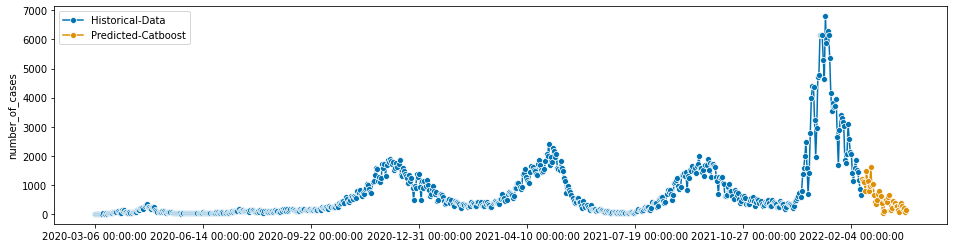

In [ ]:
forecast_period = 42 # forecast 21 days ahead
y = covid19_dataset['number_of_cases'] # the number of cases is the variable to forecast
#X = covid19_dataset.loc[:, covid19_dataset.columns != 'number_of_cases'] # X represents exogenous variables
X = covid19_dataset.loc[:, ['percent_positivity', 'active_cases']]
# X_future represents expgenous variables for the future forecasted period, for testing X_future is the last 42 points from X
X_future = X.tail(forecast_period)

fh = ForecastingHorizon(pd.date_range(start=y.index[-1]+pd.DateOffset(1), periods=forecast_period, freq='D'), 
                             is_relative=False) # forecast horizon - absolute

# Use CatBoost Regressor (initialize with tuned hyperparameters)
catRegressor = CatBoostRegressor(silent=True, iterations=220, learning_rate=0.2, l2_leaf_reg=3, max_depth=5)
catboostForecaster = make_reduction(estimator=catRegressor, strategy='direct', window_length=21, scitype='tabular-regressor')

# Note: when catboostForecaster's strategy is set to "direct", there is no need to pass exogenous variables values for the future (past covariates are enough)
catboostForecaster.fit(y=y, X=X, fh=fh)
y_pred = catboostForecaster.predict(fh=fh)

# plot
plot_series(y, y_pred, labels=["Historical-Data", "Predicted-Catboost"])